In [1]:
import os
import csv
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import MNIST

# Utils

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device = 'cpu'
print("Device used: ", device)

Device used:  cpu


In [3]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s ' % checkpoint_path)

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [5]:
# hardcoding these here
n_T = 400 # 500
n_classes = 10
n_feat = 128 # 128 ok, 256 better (but slower)
lrate = 1e-4
# ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

# Custom Dataset & DataLoader

In [6]:
class HW2P2(Dataset):
    def __init__(self, dirpath, csv_path, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # get all image names
        csv_file = open(csv_path)
        csv_reader = csv.reader(csv_file)
        i = 0
        for row in csv_reader:
            if i > 0:
                self.image_paths.append(dirpath + row[0])
                self.labels.append(int(row[1]))
            i += 1
        
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        if self.transform is not None:
            image = self.transform(image)
        image.unsqueeze(0)

        label = self.labels[index]
        label = torch.tensor(label)
        
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [7]:
dataset = HW2P2(
    dirpath='./hw2_data/digits/mnistm/data/',
    csv_path='./hw2_data/digits/mnistm/train.csv',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)

In [8]:
print("# of images in trainset: ", len(dataset))
print("# of images in testset: ", len(dataset))

# of images in trainset:  44800
# of images in testset:  44800


In [9]:
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)

In [10]:
dataiter = iter(dataloader)
images, labels = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)

Image tensor in each batch: torch.Size([256, 3, 28, 28]) torch.float32
Label tensor in each batch: torch.Size([256]) torch.int64


# Sub-Models

In [11]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = (in_channels == out_channels)
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [12]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*[ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)])

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [13]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [14]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.n_classes)
        context_mask = (-1 * (1 - context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1 * up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

# DDPM

In [15]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [16]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        # print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}', end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1 + guide_w) * eps1 - guide_w * eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i % 20 == 0 or i == self.n_T or i < 8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

# Train

In [17]:
ddpm = DDPM(nn_model=ContextUnet(in_channels=3, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)
optimizer = torch.optim.Adam(ddpm.parameters(), lr=lrate)

In [18]:
save_dir = './gen_digits/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [19]:
def inference(out_dir, num_per_digit=100):
    ddpm.eval()
    with torch.no_grad():
        n_sample = num_per_digit * n_classes
        w = 2.0
        x_gen, x_gen_store = ddpm.sample(n_sample, (3, 28, 28), device, guide_w=w)
        for c in range(10):
            for i in range(1, num_per_digit + 1, 1):
                save_image(x_gen[(i - 1) * 10 + c] * -1 + 1, out_dir + '{}_{:03d}.png'.format(c, i))

In [20]:
def train(epochs):
    for epoch in range(epochs):
        print('Epoch {}'.format(epoch))

        # train
        ddpm.train()
        optimizer.param_groups[0]['lr'] = lrate * ( 1 - epoch / epochs)
        loss_ema = None
        for batch_idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            loss = ddpm(images, labels)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()

            optimizer.step()
        print('loss: {:.4f}'.format(loss_ema))

        # test
        ddpm.eval()
        with torch.no_grad():
            n_sample = 10 * n_classes
            w = 2.0
            x_gen, x_gen_store = ddpm.sample(n_sample, (3, 28, 28), device, guide_w=w)
            save_image(make_grid(x_gen * -1 + 1, nrow=10), save_dir + 'img_epoch_{:02d}.png'.format(epoch))
            print('image saved to img_epoch_{:02d}.png'.format(epoch))

        # inference
        if epoch % 10 == 0:
            inference('./out_digit/', 40)
            os.system('python3 digit_classifier.py --folder out_digit/')
        
        save_checkpoint('./checkpoint/hw2p2/ddpm_mnistm-%i.pth' % epoch, ddpm, optimizer)
        print()
            
        

In [21]:
# train(100)

# Inference

In [22]:
load_checkpoint('./checkpoint/hw2p2/ddpm_mnistm-99.pth', ddpm, optimizer)

model loaded from ./checkpoint/hw2p2/ddpm_mnistm-99.pth 


In [23]:
# inference('./out_digit/', 100)
# os.system('python3 digit_classifier.py --folder out_digit/')

# Report

In [24]:
print(ddpm)

DDPM(
  (nn_model): ContextUnet(
    (init_conv): ResidualConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate=none)
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate=none)
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): ResidualConvBlock(
          (conv1): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate=none)
          )
          (conv2): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), st

In [26]:
ddpm.eval()
with torch.no_grad():
    n_sample = 10 * n_classes
    w = 2.0
    x_gen, x_gen_store = ddpm.sample(n_sample, (3, 28, 28), device, guide_w=w)
    save_image(make_grid(x_gen * -1 + 1, nrow=10), save_dir + 'img_final.png')
    print('image saved to img_final.png')

image saved to img_final.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


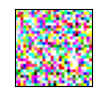

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


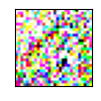

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


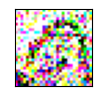

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


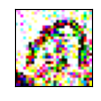

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


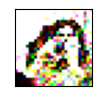

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


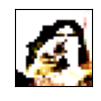

In [30]:
idx = [0, 5, 8, 11, 15, 26]
for i in range(len(idx)):
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(np.transpose(x_gen_store[idx[i]][0] * -1 + 1, (1, 2, 0)))
    plt.show()

In [33]:
def batchshow(dataloader):
    """ show the images of a batch of sample """
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.set_xticks([])
        ax.set_yticks([])
        # reshape the img from (3, 32, 32) to (32, 32, 3)
        ax.imshow(make_grid(images * -1 + 1, nrow=16).permute(1, 2, 0))
        plt.show()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


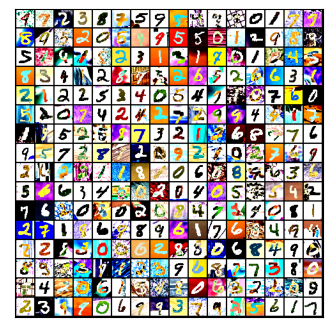

In [34]:
batchshow(dataloader)